# Midterm 1
## Goal: 
### To demonstrate understanding of a basic ETL data pipeline by extracting data from a MongoDB cluster/database/collection, a MySQL locally hosted server, and a local filesystem.

In [1]:
# Imports (unsure if all are used, cast a wide net): 

import os
from sqlalchemy import text, create_engine
import pandas as pd
import json
import datetime
import pymongo


In [2]:
#allows pd to show more columns when printing head
pd.set_option('display.max_columns', 500)

## Step 1: Load data from MySQL Sakila Data Warehouse
### My goal is to create a fact_films table created by loading data from MySQL transforming it and then loading it into a MongoDB collection
### Somewhere along the way I will use a local filesystem to create one of the tables.

In [51]:
host_name = "localhost" # the host name
port = "3306" # the port to connect on
user_id = "root" # the user id of the account
pwd = os.environ["PWD"] # an enviornmental variable invisible as I delete the cell after creating it. 

src_dbname = "sakila" #the database we are loading from

In [5]:
# function written by J. Tupitza with the purpose of loading a dataframe from a MySQL server
def get_dataframe(user_id, pwd, host_name, db_name, sql_query):
    conn_str = f"mysql+pymysql://{user_id}:{pwd}@{host_name}/{db_name}"
    sqlEngine = create_engine(conn_str, pool_recycle=3600)
    connection = sqlEngine.connect()
    dframe = pd.read_sql(sql_query, connection);
    connection.close()
    
    return dframe

In [6]:
#Loading the Films table from sakila
query = "SELECT * FROM film;"
df_film = get_dataframe(user_id, pwd, host_name, src_dbname, text(query))
df_film.head(2)

,film_id,title,description,release_year,language_id,original_language_id,rental_duration,rental_rate,length,replacement_cost,rating,special_features,last_update
0,1,ACADEMY DINOSAUR,A Epic Drama of a Feminist And a Mad Scientist...,2006,1,None,6,0.99,86,20.99,PG,"Deleted Scenes,Behind the Scenes",2006-02-15 05:03:42
1,2,ACE GOLDFINGER,A Astounding Epistle of a Database Administrat...,2006,1,None,3,4.99,48,12.99,G,"Trailers,Deleted Scenes",2006-02-15 05:03:42


In [7]:
#Loads the film_actor table from sakila
query = "SELECT * FROM film_actor;"
df_film_actor = get_dataframe(user_id, pwd, host_name, src_dbname, text(query))
df_film_actor.head(2)

,actor_id,film_id,last_update
0,1,1,2006-02-15 05:05:03
1,1,23,2006-02-15 05:05:03


In [8]:
#Loads the actor table from sakila
query = "SELECT * FROM actor;"
df_actor = get_dataframe(user_id, pwd, host_name, src_dbname, text(query))
df_actor.head(2)

,actor_id,first_name,last_name,last_update
0,1,PENELOPE,GUINESS,2006-02-15 04:34:33
1,2,NICK,WAHLBERG,2006-02-15 04:34:33


In [9]:
#loads the film_category table from sakila
query = "SELECT * FROM film_category;"
df_film_category = get_dataframe(user_id, pwd, host_name, src_dbname, text(query))
df_film_category.head(2)

,film_id,category_id,last_update
0,1,6,2006-02-15 05:07:09
1,2,11,2006-02-15 05:07:09


In [10]:
#Loads the category table from sakila
query = "SELECT * FROM category"
df_category = get_dataframe(user_id, pwd, host_name, src_dbname, text(query))
df_category.head(2)

,category_id,name,last_update
0,1,Action,2006-02-15 04:46:27
1,2,Animation,2006-02-15 04:46:27


In [11]:
#Loads the language table from sakila
query = "SELECT * FROM language"
df_language = get_dataframe(user_id, pwd, host_name, src_dbname, text(query))
df_language.head(2)

,language_id,name,last_update
0,1,English,2006-02-15 05:02:19
1,2,Italian,2006-02-15 05:02:19


# Now that data has been loaded I can begin building fact_films:

In [12]:
#The fact films table will include all of the information about the films from the actors to the categorys and descriptions, but will not have purchase/payment information. 

df_fact_films = pd.merge(df_film, df_film_actor, left_on = "film_id", right_on = "film_id", how = "left", suffixes = ('', '_film_actor'))
df_fact_films.head(1)

# now df_fact_films has an actor_id column, so I can now merge the actual actors table onto that. 

,film_id,title,description,release_year,language_id,original_language_id,rental_duration,rental_rate,length,replacement_cost,rating,special_features,last_update,actor_id,last_update_film_actor
0,1,ACADEMY DINOSAUR,A Epic Drama of a Feminist And a Mad Scientist...,2006,1,None,6,0.99,86,20.99,PG,"Deleted Scenes,Behind the Scenes",2006-02-15 05:03:42,1.0,2006-02-15 05:05:03


In [13]:
df_fact_films = pd.merge(df_fact_films, df_actor, left_on = "actor_id", right_on = "actor_id", how = "left", suffixes = ('', '_actor'))
df_fact_films.head(1)
#Now the table includes the actors first and last name, I intend to clean up duplicate/unnecessary columns at the end.

,film_id,title,description,release_year,language_id,original_language_id,rental_duration,rental_rate,length,replacement_cost,rating,special_features,last_update,actor_id,last_update_film_actor,first_name,last_name,last_update_actor
0,1,ACADEMY DINOSAUR,A Epic Drama of a Feminist And a Mad Scientist...,2006,1,None,6,0.99,86,20.99,PG,"Deleted Scenes,Behind the Scenes",2006-02-15 05:03:42,1.0,2006-02-15 05:05:03,PENELOPE,GUINESS,2006-02-15 04:34:33


In [14]:
df_fact_films = pd.merge(df_fact_films, df_film_category, left_on = "film_id", right_on = "film_id", how = "left", suffixes = ('', '_film_category'))
df_fact_films.head(1)
#now the table has film_category id and we can add the actual films category

,film_id,title,description,release_year,language_id,original_language_id,rental_duration,rental_rate,length,replacement_cost,rating,special_features,last_update,actor_id,last_update_film_actor,first_name,last_name,last_update_actor,category_id,last_update_film_category
0,1,ACADEMY DINOSAUR,A Epic Drama of a Feminist And a Mad Scientist...,2006,1,None,6,0.99,86,20.99,PG,"Deleted Scenes,Behind the Scenes",2006-02-15 05:03:42,1.0,2006-02-15 05:05:03,PENELOPE,GUINESS,2006-02-15 04:34:33,6,2006-02-15 05:07:09


In [15]:
df_fact_films = pd.merge(df_fact_films, df_category, left_on = "category_id", right_on = "category_id", how = "left", suffixes = ('', '_category'))
df_fact_films.head(1)
#now we have the actual category name as "name", I intend to change this later in the cleaning stage

,film_id,title,description,release_year,language_id,original_language_id,rental_duration,rental_rate,length,replacement_cost,rating,special_features,last_update,actor_id,last_update_film_actor,first_name,last_name,last_update_actor,category_id,last_update_film_category,name,last_update_category
0,1,ACADEMY DINOSAUR,A Epic Drama of a Feminist And a Mad Scientist...,2006,1,None,6,0.99,86,20.99,PG,"Deleted Scenes,Behind the Scenes",2006-02-15 05:03:42,1.0,2006-02-15 05:05:03,PENELOPE,GUINESS,2006-02-15 04:34:33,6,2006-02-15 05:07:09,Documentary,2006-02-15 04:46:27


In [16]:
df_fact_films = pd.merge(df_fact_films, df_language, left_on = "language_id", right_on = "language_id", how = "left", suffixes = ('','_language'))
df_fact_films.head(1)

,film_id,title,description,release_year,language_id,original_language_id,rental_duration,rental_rate,length,replacement_cost,rating,special_features,last_update,actor_id,last_update_film_actor,first_name,last_name,last_update_actor,category_id,last_update_film_category,name,last_update_category,name_language,last_update_language
0,1,ACADEMY DINOSAUR,A Epic Drama of a Feminist And a Mad Scientist...,2006,1,None,6,0.99,86,20.99,PG,"Deleted Scenes,Behind the Scenes",2006-02-15 05:03:42,1.0,2006-02-15 05:05:03,PENELOPE,GUINESS,2006-02-15 04:34:33,6,2006-02-15 05:07:09,Documentary,2006-02-15 04:46:27,English,2006-02-15 05:02:19


# df_fact_films is now ready but certainly requires some cleaning/transforming: 

In [17]:
df_fact_films.rename(columns = {'name':'category_name', 'name_language':'language'}, inplace = True)
df_fact_films.head(2)
#renamed some previously unclear column names

,film_id,title,description,release_year,language_id,original_language_id,rental_duration,rental_rate,length,replacement_cost,rating,special_features,last_update,actor_id,last_update_film_actor,first_name,last_name,last_update_actor,category_id,last_update_film_category,category_name,last_update_category,language,last_update_language
0,1,ACADEMY DINOSAUR,A Epic Drama of a Feminist And a Mad Scientist...,2006,1,None,6,0.99,86,20.99,PG,"Deleted Scenes,Behind the Scenes",2006-02-15 05:03:42,1.0,2006-02-15 05:05:03,PENELOPE,GUINESS,2006-02-15 04:34:33,6,2006-02-15 05:07:09,Documentary,2006-02-15 04:46:27,English,2006-02-15 05:02:19
1,1,ACADEMY DINOSAUR,A Epic Drama of a Feminist And a Mad Scientist...,2006,1,None,6,0.99,86,20.99,PG,"Deleted Scenes,Behind the Scenes",2006-02-15 05:03:42,10.0,2006-02-15 05:05:03,CHRISTIAN,GABLE,2006-02-15 04:34:33,6,2006-02-15 05:07:09,Documentary,2006-02-15 04:46:27,English,2006-02-15 05:02:19


In [18]:
df_fact_films.drop(columns = {'original_language_id'}, inplace = True)
df_fact_films.dropna(inplace = True)

# Now it is time to move this dataframe into my MongoDB cluster

In [53]:
host_name = "localhost"
port = "27017"

atlas_cluster_name = "dscluster"
atlas_default_dbname = "sakila"
atlas_user_name = "wloving77"
atlas_password = os.environ["PWD"] # omitted the cell defining this variable for password security. 
atlas_special_key = "iynrpaa"

conn_str = f"mongodb+srv://{atlas_user_name}:{atlas_password}@{atlas_cluster_name}.{atlas_special_key}.mongodb.net"



In [37]:
#My function that sets a mongodb collection to be the provided dataframe
def set_mongo_dataframe(connection_str, db_name, collection, df):
        client = pymongo.MongoClient(connection_str)
        db = client[db_name]
        db[collection].insert_many(df.to_dict('records'))
        client.close()

In [21]:
set_mongo_dataframe(conn_str, 'ds2002-Midterm', 'fact_films', df_fact_films)

## Now I will prove it was inserted

In [22]:
#Professor Tupitza's function from Lab4
def get_mongo_dataframe(connect_str, db_name, collection, query):
    '''Create a connection to MongoDB'''
    client = pymongo.MongoClient(connect_str)
    
    '''Query MongoDB, and fill a python list with documents to create a DataFrame'''
    db = client[db_name]
    dframe = pd.DataFrame(list(db[collection].find(query)))
    dframe.drop(['_id'], axis=1, inplace=True)
    client.close()
    return dframe


In [23]:
df_fact_films2 = get_mongo_dataframe(conn_str, 'ds2002-Midterm', 'fact_films', '')
df_fact_films2.head(2)
#The table was actually loaded!

,film_id,title,description,release_year,language_id,rental_duration,rental_rate,length,replacement_cost,rating,special_features,last_update,actor_id,last_update_film_actor,first_name,last_name,last_update_actor,category_id,last_update_film_category,category_name,last_update_category,language,last_update_language
0,1,ACADEMY DINOSAUR,A Epic Drama of a Feminist And a Mad Scientist...,2006,1,6,0.99,86,20.99,PG,"Deleted Scenes,Behind the Scenes",2006-02-15 05:03:42,1.0,2006-02-15 05:05:03,PENELOPE,GUINESS,2006-02-15 04:34:33,6,2006-02-15 05:07:09,Documentary,2006-02-15 04:46:27,English,2006-02-15 05:02:19
1,1,ACADEMY DINOSAUR,A Epic Drama of a Feminist And a Mad Scientist...,2006,1,6,0.99,86,20.99,PG,"Deleted Scenes,Behind the Scenes",2006-02-15 05:03:42,10.0,2006-02-15 05:05:03,CHRISTIAN,GABLE,2006-02-15 04:34:33,6,2006-02-15 05:07:09,Documentary,2006-02-15 04:46:27,English,2006-02-15 05:02:19


# Now to load the rest of the data into mongodb to complete the "data mart" :

In [30]:
set_mongo_dataframe(conn_str, 'ds2002-Midterm', 'film_actor' , df_film_actor)

In [31]:
set_mongo_dataframe(conn_str, 'ds2002-Midterm', 'film' , df_film)

In [32]:
set_mongo_dataframe(conn_str, 'ds2002-Midterm', 'actor' , df_actor)

In [33]:
set_mongo_dataframe(conn_str, 'ds2002-Midterm', 'film_category' , df_film_category)

In [34]:
set_mongo_dataframe(conn_str, 'ds2002-Midterm', 'category' , df_category)

In [35]:
set_mongo_dataframe(conn_str, 'ds2002-Midterm', 'language' , df_language)

# Data mart now established, all dataframes loaded into the 'ds2002-Midterm' Collection with the above tables as well as fact_films. 

## Now to load a table from a local directory into a dataframe and then into the cloud data mart:

In [24]:
data_dir = os.path.join(os.getcwd(), 'film_text.csv')
print(data_dir)

C:\Users\wlovi\OneDrive\Desktop\GitHubRepo's\ds2002\film_text.csv


In [25]:
df_film_text = pd.read_csv(data_dir, sep = ";")
df_film_text = df_film_text.reset_index(drop = True)
df_film_text.head(5)

,film_id,title,description
0,1,ACADEMY DINOSAUR,A Epic Drama of a Feminist And a Mad Scientist...
1,2,ACE GOLDFINGER,A Astounding Epistle of a Database Administrat...
2,3,ADAPTATION HOLES,A Astounding Reflection of a Lumberjack And a ...
3,4,AFFAIR PREJUDICE,A Fanciful Documentary of a Frisbee And a Lumb...
4,5,AFRICAN EGG,A Fast-Paced Documentary of a Pastry Chef And ...


In [38]:
set_mongo_dataframe(conn_str, 'ds2002-Midterm', 'film_text' , df_film_text)

# Now I will load all of this data into it's own data warehouse on my local SQL server

In [26]:
#Professor Tupitza's function for setting a table in a sql server. 
def set_dataframe(user_id, pwd, host_name, db_name, df, table_name, pk_column, db_operation):
    conn_str = f"mysql+pymysql://{user_id}:{pwd}@{host_name}/{db_name}"
    sqlEngine = create_engine(conn_str, pool_recycle=360)
    connection = sqlEngine.connect()
        
    if db_operation == "insert":
        df.to_sql(table_name, schema = db_name, con = sqlEngine, index=False, if_exists='replace')
        #connection.execute(text(f"ALTER TABLE {table_name} ADD PRIMARY KEY ({pk_column});"))
            
    elif db_operation == "update":
        df.to_sql(table_name, schema=db_name,con=connection, index=False, if_exists='append')
    
    connection.close()

In [27]:
conn_str = f"mysql+pymysql://{user_id}:{pwd}@{host_name}"
sqlEngine = create_engine(conn_str, pool_recycle=3600)

conn = sqlEngine.connect()

conn.execute(text("DROP DATABASE IF EXISTS `ds2002-Midterm`;"))
conn.execute(text("CREATE DATABASE `ds2002-Midterm`;"))

dst_dbname = 'ds2002-Midterm'

conn.close()


In [28]:
tables = [('fact_films', df_fact_films, 'film_id'), ('film', df_film, 'film_id'), ('film_actor', df_film_actor, 'actor_id'), ('actor', df_actor, 'actor_id'), 
          ('film_category', df_film_category, 'film_id'), ('category', df_category, 'category_id'), ('language', df_language, 'language_id'), ('film_text', df_film_text, 'film_id'),]

db_operation = "insert"

for table_name, dataframe, primary_key in tables:
    set_dataframe(user_id, pwd, host_name, dst_dbname, dataframe, table_name, primary_key, db_operation)

# Data mart is finished! It is all loaded into the MongoDB database as well as the local MySQL server!

## dim_date added below, sql scripts run on MySQL will be submitted alongside this. 

In [34]:
query = "SELECT * FROM dim_date;"
df_dim_date = get_dataframe(user_id, pwd, host_name, 'ds2002-midterm', text(query))
df_dim_date.head(2)

,date_key,full_date,date_name,date_name_us,date_name_eu,day_of_week,day_name_of_week,day_of_month,day_of_year,weekday_weekend,week_of_year,month_name,month_of_year,is_last_day_of_month,calendar_quarter,calendar_year,calendar_year_month,calendar_year_qtr,fiscal_month_of_year,fiscal_quarter,fiscal_year,fiscal_year_month,fiscal_year_qtr
0,20050101,2005-01-01,2005/01/01,01/01/2005,01/01/2005,7,Saturday,1,1,Weekend,53,January,1,N,1,2005,2005-01,2005Q1,7,3,2005,2005-07,2005Q3
1,20050102,2005-01-02,2005/01/02,01/02/2005,02/01/2005,1,Sunday,2,2,Weekend,53,January,1,N,1,2005,2005-01,2005Q1,7,3,2005,2005-07,2005Q3


In [46]:
import datetime

#Changes datetime.date to be datetime.datetime for compatibility with mongo. 

for col in df_dim_date.columns:
    df_dim_date[col] = df_dim_date[col].apply(lambda d: datetime.datetime.combine(d, datetime.time.min) if isinstance(d, datetime.date) else d)
        


In [47]:
set_mongo_dataframe(conn_str, 'ds2002-Midterm', 'dim_date', df_dim_date)

In [52]:
#Update the fact_films so that it has the date_key's 
query = "SELECT * FROM fact_films;"
df_fact_films = get_dataframe(user_id, pwd, host_name, 'ds2002-midterm', text(query))

In [55]:
set_mongo_dataframe(conn_str, 'ds2002-Midterm', 'fact_films', df_fact_films)

## Screenshots turned in alongside this notebook for proof

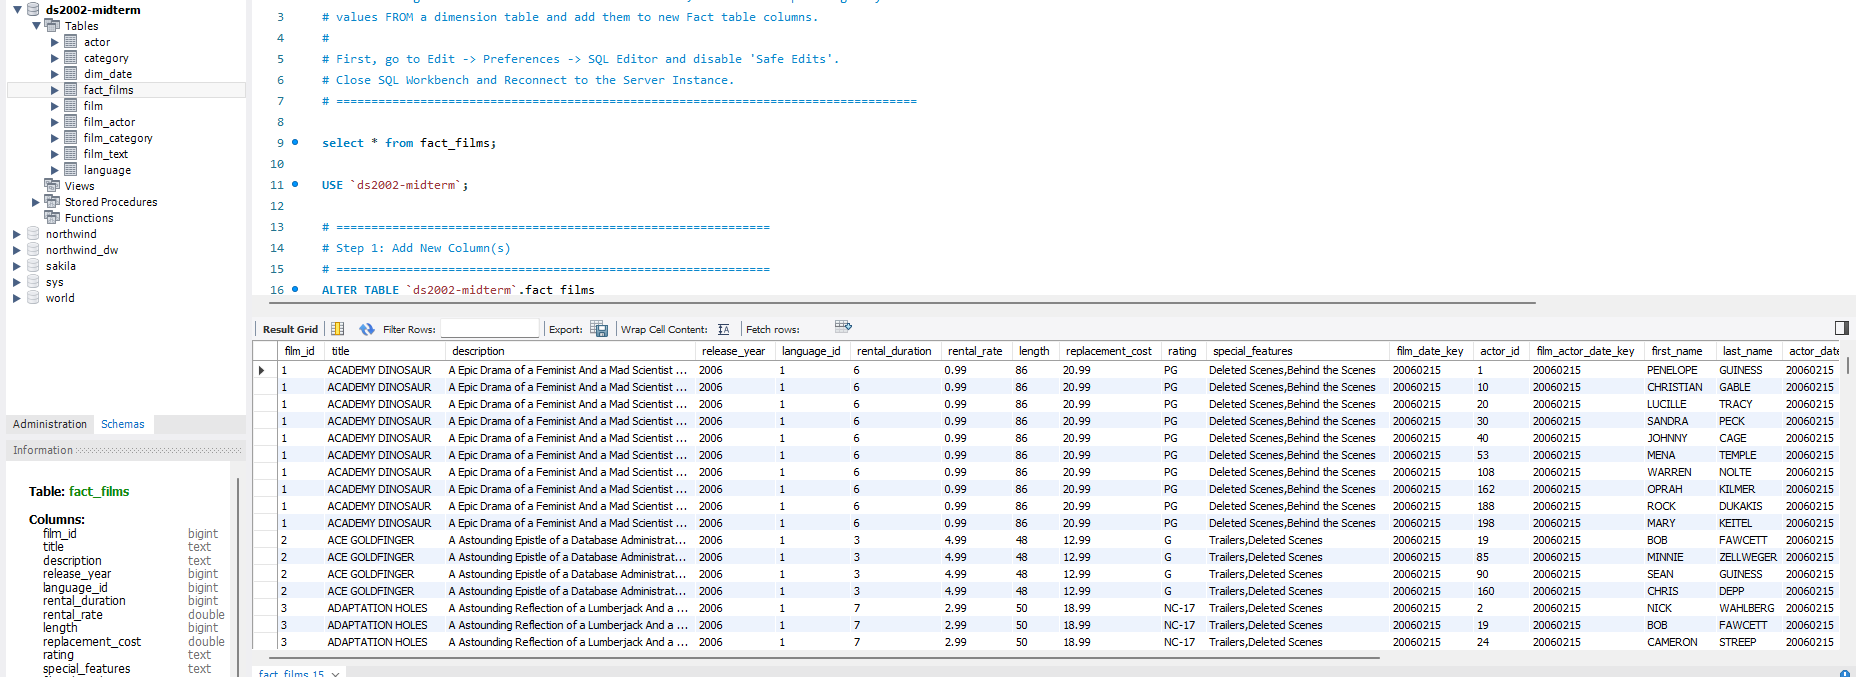

In [48]:
from IPython.display import Image
Image(filename='sql_data_mart.png') 

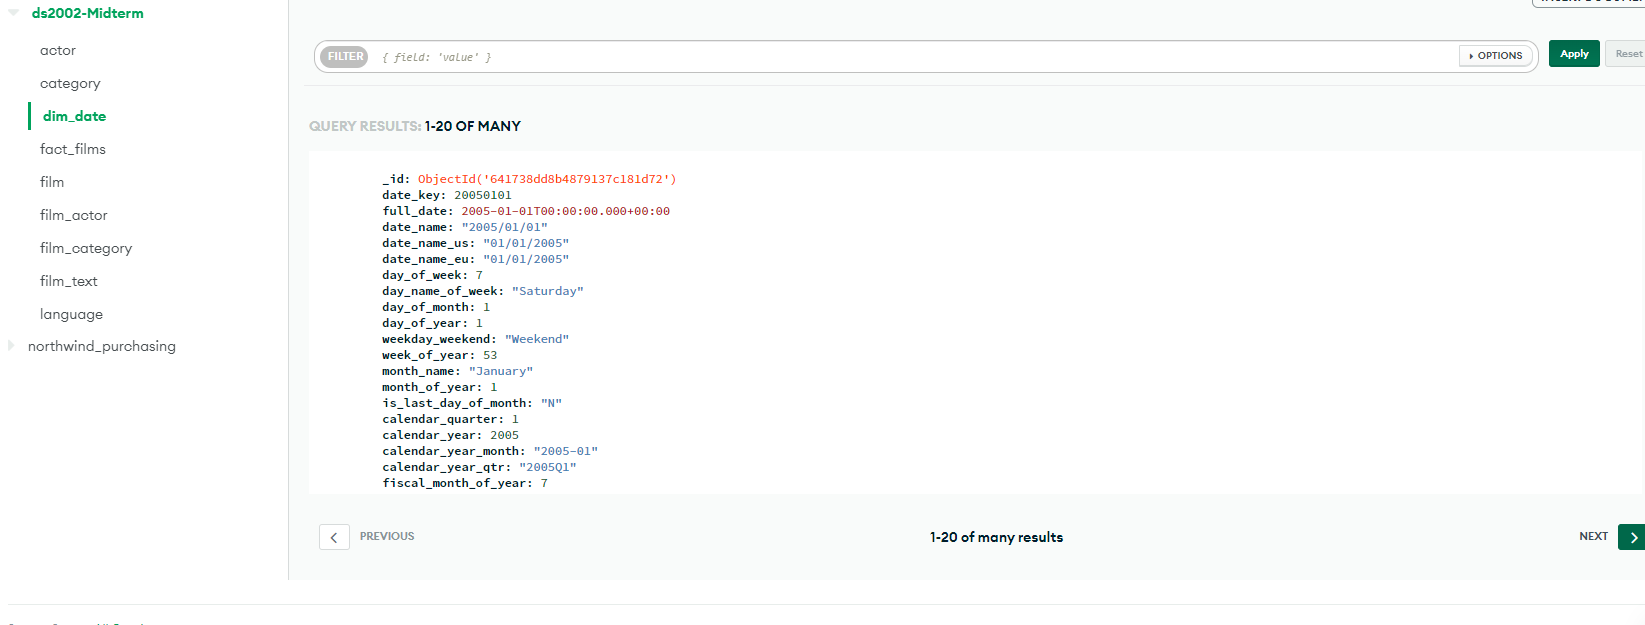

In [50]:
Image(filename='mongodb_data_mart.png')